<a href="https://colab.research.google.com/github/nonono-copen/signate_Prediction_of_Liver_Disease/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/ 'My Drive'/signate/健診データによる肝疾患判定

Mounted at /content/drive
/content/drive/ My Drive/signate/健診データによる肝疾患判定


In [2]:
""" 必要なライブラリをimport"""
import argparse
import operator
import os
import time
from   collections import OrderedDict
from   tqdm        import tqdm


import torch
import torch.nn                    as nn
import torch.utils.data            as data
from   torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.transforms as transforms

import csv
import numpy              as     np
import pandas             as     pd
import seaborn            as     sns   # データの傾向確認用
from   sklearn               import preprocessing
from   sklearn.preprocessing import OrdinalEncoder

from   PIL                import Image
from   pathlib            import Path
from   matplotlib         import pyplot as plt
# %matplotlib inline  # Jupyter Notebookでインライン表示する
from   torch.autograd     import Variable
from   IPython.display    import display
from   torchvision.utils  import save_image # テスト用

In [3]:
 # 学習用csvデータ確認
 df = pd.read_table('./dataset/train.csv', sep=',')
 df.columns = ['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio', 'disease']
 df.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [4]:
# ラベルエンコーディング（OrdinalEncoder）
oe      = preprocessing.OrdinalEncoder()
encoded = oe.fit_transform(df[['Gender']].values)

# データフレームを作成
encodered_df = pd.DataFrame(encoded, columns= ['Gender_enc'])
# decoded = oe.inverse_transform(encoded)
# エンコードしたデータに差し替え
df.insert(loc = 2, column= 'Gender_enc', value= encodered_df)
df = df.drop(columns='Gender') # エンコード前のGender列を削除
df.head()

,Age,Gender_enc,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,1.0,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,1.0,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,1.0,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,1.0,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,0.0,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


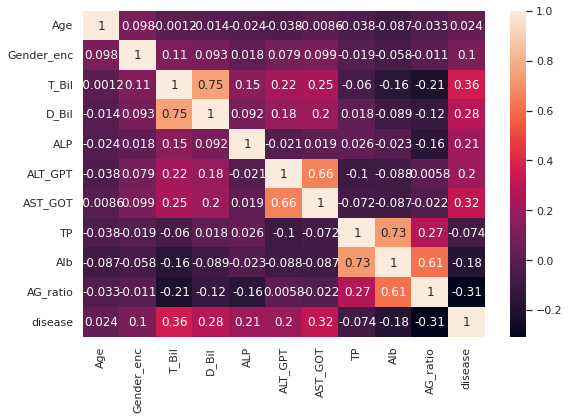

In [5]:
# データの可視化
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
sns.set(style='darkgrid')

plt.figure(figsize=(9,6))
sns.heatmap(df.corr(), annot=True)

In [6]:
# Age(0列目)〜AG_ration(10列目)を特徴量として使う
X = df.iloc[:, :10]
X.head()

,Age,Gender_enc,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,59,1.0,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802
1,69,1.0,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346
2,65,1.0,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952
3,65,1.0,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155
4,22,0.0,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654


In [7]:
# disease(11列目)を特徴量として使う
y = df.iloc[:,10:11]
y.head()

,disease
0,0
1,1
2,0
3,1
4,0


In [8]:
# 相関の低いカラムを削除
# X = X.drop(columns='Age') 
# X = X.drop(columns='Gender_enc')
# X = X.drop(columns='TP')
# X.head()

一旦モデルに突っ込んでみる

In [9]:
# LightGBMで学習
from   sklearn.metrics         import accuracy_score, roc_auc_score
from   sklearn.model_selection import KFold
import lightgbm as lgb
import numpy    as np
# 警告を非表示
import warnings
warnings.simplefilter('ignore')

# パラメータ
FOLD             = 5              # 交差検証の分ける回数
NUM_ROUND        = 30000          # 学習ステップ数
VERBOSE_EVAL     = 10000          # 学習結果の表示ステップ数
SEED             = 42             # ランダム値のシード（再現性を持たせるため）
categorical_list = ['Gender_enc'] # カテゴリ変数


# LightGBMパラメータチューニング（よく使われる値で検証）
params = {
    'objective'       : 'binary',
    'boosting_type'   : 'gbdt',  # default = gbdt
    'num_leaves'      : 63,      # default = 31
    'max_depth'       : -1,      # default = -1(上限なし)
    'learning_rate'   : 1e-2,    # default = 0.1
    'feature_fraction': 0.8,     # default = 1.0
    'bagging_freq'    : 1,       # default = 0
    'random_state'    : SEED,    # default = None
    'metric'          : 'binary_logloss'   # default = 'binary_logloss',
}

valid_auc    = []
valid_acc    = []
models       = []
result_data  = {}

# kFold交差検定で決定係数を算出し、各セットの平均値を返す
kf = KFold(n_splits=FOLD, shuffle=True, random_state=42)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
    # 指定したindexで学習・評価データを分ける
    X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices] 
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices] 

    train_data = lgb.Dataset(X_train, y_train) 
    valid_data = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params = params,
        train_set             = train_data,
        valid_sets            = [train_data, valid_data],
        categorical_feature   = categorical_list,         # カテゴリ値のカラムを指定(やらんでも動く)
        num_boost_round       = NUM_ROUND,
        early_stopping_rounds = 5,
        verbose_eval          = VERBOSE_EVAL,
        evals_result          = result_data
    )

    # 学習したモデルでバリデーションデータを予測
    y_valid_pred = model.predict(X_valid)

    # aucを計算（本問題の運営側 評価方法）
    auc = roc_auc_score(y_valid.to_numpy().squeeze(), y_valid_pred) # 引数：正解データ & 予測データ
    valid_auc.append(auc)

    # 正解率を計算
    acc = accuracy_score(y_valid.to_numpy().squeeze(),np.round(y_valid_pred)) # 引数：正解データ & 予測データ(四捨五入（銀行丸めになっている点は注意)）
    valid_acc.append(acc)

# 交差検証の正解率の平均
cv_acc = np.mean(valid_acc)
cv_auc = np.mean(valid_auc)
print('Accuracy: {}, auc: {}'.format(cv_acc, cv_auc))

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.158642	valid_1's binary_logloss: 0.259014
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.12922	valid_1's binary_logloss: 0.291263
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.196859	valid_1's binary_logloss: 0.380619
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.137485	valid_1's binary_logloss: 0.292823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.146664	valid_1's binary_logloss: 0.334526
Accuracy: 0.868235294117647, auc: 0.940234606031624


Optunaでハイパーパラメータ探索

In [10]:
# ライブラリのインストール
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 22.5 MB/s 
     |████████████████████████████████| 209 kB 44.0 MB/s 
     |████████████████████████████████| 81 kB 9.6 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 147 kB 55.3 MB/s 
     |████████████████████████████████| 112 kB 54.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=d30e464f0962514fbb86c12e2f351184bf39e13417608c1d3d23c87ff8d1bef4
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.0.0
    Uninstalling importlib-metadata-5.0.0:
      Successfully uninstalled importlib-metadata-5.0.0


In [13]:
# Optunaによるハイパラ探索
from   sklearn.metrics         import accuracy_score, roc_auc_score
from   sklearn.model_selection import KFold
import lightgbm as lgb
import numpy    as np
import optuna

# 警告を非表示
import warnings
warnings.simplefilter('ignore')

# パラメータ
FOLD             = 5              # 交差検証の分ける回数
NUM_ROUND        = 30000          # 学習ステップ数
VERBOSE_EVAL     = 5000           # 学習結果の表示ステップ数
SEED             = 42             # ランダム値のシード（再現性を持たせるため）
# categorical_list = ['Gender_enc'] # カテゴリ変数


def objective(trial):
    # LightGBMパラメータ(Optunaで探索)
    params = {
      'objective'       : 'binary',
      'boosting_type'   : trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),  # default = gbdt
      'num_leaves'      : trial.suggest_int('num_leaves', 10, 1000),                             # default = 31
      'max_depth'       : -1,      # default = -1(上限なし)
      'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-8, 1.0),                  # default = 0.1
      'feature_fraction': 0.8,     # default = 1.0
      'bagging_freq'    : 1,       # default = 0
      'random_state'    : SEED,    # default = None
      'metric'          : trial.suggest_categorical('metrics', ['binary_logloss', 'rmse', 'auc']),  # default = 'binary_logloss',
    }

    valid_auc    = []
    valid_acc    = []
    models       = []
    result_data  = {}

    # kFold交差検定で決定係数を算出し、各セットの平均値を返す
    kf = KFold(n_splits=FOLD, shuffle=True, random_state=42)
    for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
      # 指定したindexで学習・評価データを分ける
      X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices] 
      y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices] 

      train_data = lgb.Dataset(X_train, y_train) 
      valid_data = lgb.Dataset(X_valid, y_valid)

      model = lgb.train(
          params = params,
          train_set             = train_data,
          valid_sets            = [train_data, valid_data],
          # categorical_feature   = categorical_list,         # カテゴリ値のカラムを指定(やらんでも動く)
          num_boost_round       = NUM_ROUND,
          early_stopping_rounds = 5,
          verbose_eval          = VERBOSE_EVAL,
          evals_result          = result_data
      )

      # 学習したモデルでバリデーションデータを予測
      y_valid_pred = model.predict(X_valid)

      # aucを計算（本問題の運営側 評価方法）
      auc = roc_auc_score(y_valid.to_numpy().squeeze(), y_valid_pred) # 引数：正解データ & 予測データ
      valid_auc.append(auc)

      # 正解率を計算
      acc = accuracy_score(y_valid.to_numpy().squeeze(),np.round(y_valid_pred)) # 引数：正解データ & 予測データ(四捨五入（銀行丸めになっている点は注意)）
      valid_acc.append(acc)

    # 交差検証の正解率の平均 accを最大化
    cv_acc = np.mean(valid_acc)
    cv_auc = np.mean(valid_auc)
    print('Accuracy: {}, auc: {}'.format(cv_acc, cv_auc))
    return cv_acc

# Optunaでハイパーパラメータ探索
study = optuna.create_study(direction='maximize') # 今回は正解率（Accuracy）を最大化（本当はAUC最大化の方が良い）
study.optimize(objective, n_trials=10)            # 試行回数10回

[I 2022-10-11 14:22:13,924] A new study created in memory with name: no-name-44a35d04-aeb8-43e9-a19c-6239c51c69cc


Training until validation scores don't improve for 5 rounds.
[5000]	training's rmse: 0.43194	valid_1's rmse: 0.433298
[10000]	training's rmse: 0.382986	valid_1's rmse: 0.386992
[15000]	training's rmse: 0.345166	valid_1's rmse: 0.352819
[20000]	training's rmse: 0.315951	valid_1's rmse: 0.328024
[25000]	training's rmse: 0.300345	valid_1's rmse: 0.314326
[30000]	training's rmse: 0.288924	valid_1's rmse: 0.304917
Did not meet early stopping. Best iteration is:
[30000]	training's rmse: 0.288924	valid_1's rmse: 0.304917
Training until validation scores don't improve for 5 rounds.
[5000]	training's rmse: 0.431433	valid_1's rmse: 0.439448
[10000]	training's rmse: 0.38144	valid_1's rmse: 0.400654
[15000]	training's rmse: 0.343702	valid_1's rmse: 0.373355
[20000]	training's rmse: 0.31521	valid_1's rmse: 0.354498
[25000]	training's rmse: 0.299722	valid_1's rmse: 0.343897
[30000]	training's rmse: 0.288502	valid_1's rmse: 0.336323
Did not meet early stopping. Best iteration is:
[30000]	training's r

[I 2022-10-11 14:25:52,972] Trial 0 finished with value: 0.8576470588235294 and parameters: {'boosting_type': 'goss', 'num_leaves': 520, 'learning_rate': 4.8605705235796566e-05, 'metrics': 'rmse'}. Best is trial 0 with value: 0.8576470588235294.


Accuracy: 0.8576470588235294, auc: 0.9371909713605158
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[3]	training's auc: 0.95813	valid_1's auc: 0.965228
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[4]	training's auc: 0.963344	valid_1's auc: 0.922312
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.971216	valid_1's auc: 0.906786
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.974011	valid_1's auc: 0.9425
Training until validation scores don't improve for 5 rounds.


[I 2022-10-11 14:25:53,170] Trial 1 finished with value: 0.5552941176470588 and parameters: {'boosting_type': 'goss', 'num_leaves': 914, 'learning_rate': 6.589875128638541e-05, 'metrics': 'auc'}. Best is trial 0 with value: 0.8576470588235294.


Early stopping, best iteration is:
[10]	training's auc: 0.972691	valid_1's auc: 0.914456
Accuracy: 0.5552941176470588, auc: 0.9302565209429637
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.144021	valid_1's binary_logloss: 0.258011
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.139904	valid_1's binary_logloss: 0.297356
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.129063	valid_1's binary_logloss: 0.359898
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.131968	valid_1's binary_logloss: 0.286691
Training until validation scores don't improve for 5 rounds.


[I 2022-10-11 14:25:54,558] Trial 2 finished with value: 0.8647058823529411 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 372, 'learning_rate': 0.01707955583422816, 'metrics': 'binary_logloss'}. Best is trial 2 with value: 0.8647058823529411.


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.116089	valid_1's binary_logloss: 0.323063
Accuracy: 0.8647058823529411, auc: 0.9446858497609428
Training until validation scores don't improve for 5 rounds.
[5000]	training's rmse: 0.299776	valid_1's rmse: 0.315655
Early stopping, best iteration is:
[9542]	training's rmse: 0.233939	valid_1's rmse: 0.282254
Training until validation scores don't improve for 5 rounds.
[5000]	training's rmse: 0.299775	valid_1's rmse: 0.346091
[10000]	training's rmse: 0.23292	valid_1's rmse: 0.320079
Early stopping, best iteration is:
[12047]	training's rmse: 0.212677	valid_1's rmse: 0.314781
Training until validation scores don't improve for 5 rounds.
[5000]	training's rmse: 0.290984	valid_1's rmse: 0.360941
Early stopping, best iteration is:
[9442]	training's rmse: 0.224125	valid_1's rmse: 0.34249
Training until validation scores don't improve for 5 rounds.
[5000]	training's rmse: 0.292867	valid_1's rmse: 0.33878
Early stopping, best i

[I 2022-10-11 14:26:56,787] Trial 3 finished with value: 0.8588235294117647 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 936, 'learning_rate': 0.00022793320883565955, 'metrics': 'rmse'}. Best is trial 2 with value: 0.8647058823529411.


Accuracy: 0.8588235294117647, auc: 0.9385632475278376
[5000]	training's binary_logloss: 5.55088e-06	valid_1's binary_logloss: 1.11723
[10000]	training's binary_logloss: 4.95727e-06	valid_1's binary_logloss: 1.32521
[15000]	training's binary_logloss: 4.80311e-06	valid_1's binary_logloss: 1.44342
[20000]	training's binary_logloss: 4.75048e-06	valid_1's binary_logloss: 1.61871
[25000]	training's binary_logloss: 4.66073e-06	valid_1's binary_logloss: 1.70336
[30000]	training's binary_logloss: 4.63895e-06	valid_1's binary_logloss: 1.74882
[5000]	training's binary_logloss: 5.48703e-06	valid_1's binary_logloss: 0.979431
[10000]	training's binary_logloss: 4.86131e-06	valid_1's binary_logloss: 1.16657
[15000]	training's binary_logloss: 4.77896e-06	valid_1's binary_logloss: 1.27842
[20000]	training's binary_logloss: 4.73048e-06	valid_1's binary_logloss: 1.41656
[25000]	training's binary_logloss: 4.66448e-06	valid_1's binary_logloss: 1.52799
[30000]	training's binary_logloss: 4.65361e-06	valid_1's

[I 2022-10-11 14:31:23,571] Trial 4 finished with value: 0.8294117647058824 and parameters: {'boosting_type': 'dart', 'num_leaves': 740, 'learning_rate': 0.8359288433599077, 'metrics': 'binary_logloss'}. Best is trial 2 with value: 0.8647058823529411.


Accuracy: 0.8294117647058824, auc: 0.9063069625979427
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.179554	valid_1's binary_logloss: 0.266584
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.115139	valid_1's binary_logloss: 0.298668
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.108761	valid_1's binary_logloss: 0.373304
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.135722	valid_1's binary_logloss: 0.293203
Training until validation scores don't improve for 5 rounds.


[I 2022-10-11 14:31:23,777] Trial 5 finished with value: 0.8658823529411765 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'learning_rate': 0.2314089944611747, 'metrics': 'binary_logloss'}. Best is trial 5 with value: 0.8658823529411765.
[I 2022-10-11 14:31:23,960] Trial 6 finished with value: 0.5552941176470588 and parameters: {'boosting_type': 'goss', 'num_leaves': 890, 'learning_rate': 1.589281502691709e-07, 'metrics': 'auc'}. Best is trial 5 with value: 0.8658823529411765.


Early stopping, best iteration is:
[22]	training's binary_logloss: 0.0796197	valid_1's binary_logloss: 0.314074
Accuracy: 0.8658823529411765, auc: 0.9443382949871715
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[3]	training's auc: 0.95813	valid_1's auc: 0.965228
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[4]	training's auc: 0.963344	valid_1's auc: 0.922312
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.971251	valid_1's auc: 0.907286
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[4]	training's auc: 0.973633	valid_1's auc: 0.945139
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.972683	valid_1's auc: 0.914456
Accuracy: 0.5552941176470588, auc: 0.9308842987207416


[I 2022-10-11 14:31:24,150] Trial 7 finished with value: 0.5552941176470588 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 973, 'learning_rate': 1.857658506134504e-05, 'metrics': 'auc'}. Best is trial 5 with value: 0.8658823529411765.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[3]	training's auc: 0.95813	valid_1's auc: 0.965228
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[4]	training's auc: 0.963344	valid_1's auc: 0.922312
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.971216	valid_1's auc: 0.906786
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.974011	valid_1's auc: 0.9425
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.972691	valid_1's auc: 0.914456
Accuracy: 0.5552941176470588, auc: 0.9302565209429637
[5000]	training's binary_logloss: 0.691176	valid_1's binary_logloss: 0.691253
[10000]	training's binary_logloss: 0.689872	valid_1's binary_logloss: 0.689852
[15000]	training's binary_logloss: 0.688389	v

[I 2022-10-11 14:42:58,677] Trial 8 finished with value: 0.8435294117647059 and parameters: {'boosting_type': 'dart', 'num_leaves': 980, 'learning_rate': 1.2831638180554867e-06, 'metrics': 'binary_logloss'}. Best is trial 5 with value: 0.8658823529411765.


Accuracy: 0.8435294117647059, auc: 0.9328684469644191
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[4]	training's auc: 0.967062	valid_1's auc: 0.966345
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[26]	training's auc: 0.99265	valid_1's auc: 0.950028
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.976823	valid_1's auc: 0.908929
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[18]	training's auc: 0.990319	valid_1's auc: 0.947222


[I 2022-10-11 14:42:59,344] Trial 9 finished with value: 0.851764705882353 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'learning_rate': 0.11025157664882144, 'metrics': 'auc'}. Best is trial 5 with value: 0.8658823529411765.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[12]	training's auc: 0.984584	valid_1's auc: 0.929333
Accuracy: 0.851764705882353, auc: 0.9403715209958717


In [14]:
print(study.best_params)
print(study.best_value)

{'boosting_type': 'gbdt', 'num_leaves': 253, 'learning_rate': 0.2314089944611747, 'metrics': 'binary_logloss'}
0.8658823529411765


In [16]:
# Optunaで探索したベストハイパラでLightGBMを再学習
params = {
    'objective'       : 'binary',
    'boosting_type'   : study.best_params['boosting_type'], # Optunaで探索した値を指定
    'num_leaves'      : study.best_params['num_leaves'],    # Optunaで探索した値を指定
    'max_depth'       : -1,                                 # default = -1(上限なし)
    'learning_rate   ': study.best_params['learning_rate'], # Optunaで探索した値を指定
    'feature_fraction': 0.8,                                # default = 1.0
    'bagging_freq'    : 1,                                  # default = 0
    'random_state'    : 0,                                  # default = None
    'metric'          : study.best_params['metrics'],       # Optunaで探索した値を指定
    'seed'            : SEED
}

valid_scores = []
valid_acc    = []
models       = []
result_data  = {}

# kFold交差検定で決定係数を算出し、各セットの平均値を返す
kf = KFold(n_splits=FOLD, shuffle=True, random_state=42)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices] # 指定したindexで学習・評価データを分ける
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices] 

    train_data = lgb.Dataset(X_train, y_train) 
    valid_data = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params = params,
        train_set             = train_data,
        valid_sets            = [train_data, valid_data],
        categorical_feature   = categorical_list, # categorical_featureを設定
        num_boost_round       = NUM_ROUND,
        early_stopping_rounds = 5,
        verbose_eval          = VERBOSE_EVAL,
        evals_result          = result_data
    )
    
    # 学習したモデルでバリデーションデータを予測
    y_valid_pred = model.predict(X_valid)

    # aucを計算（本問題の運営側 評価方法）
    auc = roc_auc_score(y_valid.to_numpy().squeeze(), y_valid_pred) # 引数：正解データ & 予測データ
    valid_auc.append(auc)

    # 正解率を計算
    acc = accuracy_score(y_valid.to_numpy().squeeze(),np.round(y_valid_pred)) # 引数：正解データ & 予測データ(四捨五入（銀行丸めになっている点は注意)）
    valid_acc.append(acc)
    print('fold {} Accuracy:{}, auc:{}'.format(fold, acc, auc))

    # モデルを保存
    models.append(model)

# 交差検証の正解率の平均
cv_acc = np.mean(valid_acc)
cv_auc = np.mean(valid_auc)
print('Accuracy: {}, auc: {}'.format(cv_acc, cv_auc))

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.126413	valid_1's binary_logloss: 0.249066
fold 0 Accuracy:0.888235294117647, auc:0.9674626448819997
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.13005	valid_1's binary_logloss: 0.305679
fold 1 Accuracy:0.8588235294117647, auc:0.9469484882418813
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.1267	valid_1's binary_logloss: 0.358168
fold 2 Accuracy:0.8764705882352941, auc:0.9225714285714286
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0912421	valid_1's binary_logloss: 0.297299
fold 3 Accuracy:0.8764705882352941, auc:0.9469444444444444
Training until validation scores don't improve for 5 rounds.
Early stopping, be

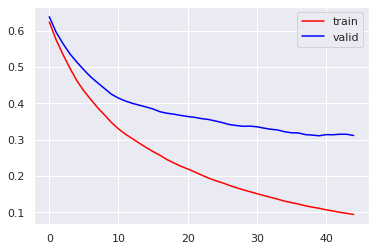

In [17]:
# 最後のモデルだけ学習過程を表示
import matplotlib.pyplot as plt
plt.plot(result_data["training"]["binary_logloss"], color = "red", label = "train")
plt.plot(result_data["valid_1"]["binary_logloss"], color = "blue", label = "valid")
plt.legend()
plt.show()

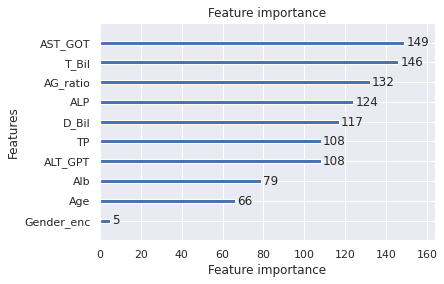

In [18]:
import matplotlib
# 特徴量の重要度を表示
lgb.plot_importance(model) # 最後のモデルデータのみ表示

In [ ]:
# # アンサンブルで予測
# y_preds = []
# for model in models:
#   y_pred = model.predict(X_valid)
#   y_preds.append(y_pred)

# prediction = np.mean(y_preds, axis=0)
# acc = accuracy_score(y_valid.to_numpy().squeeze(), np.round(prediction)) # 引数：正解データ & 予測データ(四捨五入（銀行丸めになっている点は注意)）
# print('accuracy:{}'.format(acc))

アップロード用データ作成

In [19]:
# 評価用 test_csvデータ確認
testdata_df = pd.read_table('./dataset/test.csv', sep=',')
testdata_df.columns = ['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']
# ラベルエンコーディング（OrdinalEncoder）
# oe      = preprocessing.OrdinalEncoder()
testdata_encoded = oe.fit_transform(testdata_df[['Gender']].values)

# データフレームを作成
encodered_testdata_df = pd.DataFrame(testdata_encoded, columns= ['Gender_enc'])
# decoded = oe.inverse_transform(encoded)
# エンコードしたデータに差し替え
testdata_df.insert(loc = 2, column= 'Gender_enc', value= encodered_testdata_df)
testdata_df = testdata_df.drop(columns='Gender') # エンコード前のGender列を削除

# 相関の低いカラムを削除 (Age, Gender_enc, TP, Alb)
# testdata_df = testdata_df.drop(columns='Age') 
# testdata_df = testdata_df.drop(columns='Gender_enc')

# アンサンブルで予測
test_y_preds = []
for model in models:
  test_y_pred = model.predict(testdata_df)
  test_y_preds.append(test_y_pred)

test_prediction = np.mean(test_y_preds, axis=0)

# CSV化
testdata_pred_df = pd.DataFrame(test_prediction)
testdata_pred_df.to_csv('./submit.csv', header=False)